# Import

In [ ]:
# !pip install rdkit
# !pip install albumentations

In [2]:
import random
import os

from tqdm import tqdm

import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment',  None)

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from rdkit import DataStructs
from rdkit.Chem import PandasTools, AllChem

In [3]:
import os
import random
import numpy as np
import torch

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [18]:
class CFG:
    SEED = 42
    IMG_SIZE = 224
    BATCH_SIZE = 64
    EPOCHS = 1024
    LEARNING_RATE = 0.003

<br></br>

# Data Load

In [5]:
train_df = pd.read_csv('./data/train.csv')
test_df  = pd.read_csv('./data/test.csv')

In [6]:
train_df.head()

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43


<br></br>

# EDA

In [ ]:
# train_df.describe()

In [ ]:
# num_features = train_df.columns[train_df.dtypes!='object'].tolist()
# for i,col in enumerate(num_features):

#     fig = plt.figure(figsize=(15,7))
#     fig.add_subplot(121)
#     sns.histplot(train_df[col],bins=20)
#     plt.grid()

#     fig.add_subplot(122)
#     sns.histplot(np.log(train_df[col]+1e-3),bins=20)
#     plt.grid()

#     plt.suptitle('[{}/{}] {}'.format(i+1,len(num_features),col))
#     plt.tight_layout()
#     plt.show()

# # -> ['Molecular_Weight','Molecular_PolarSurfaceArea']

In [ ]:
# cols = ['AlogP','Molecular_Weight','Num_H_Acceptors','Num_H_Donors','Num_RotatableBonds','LogD','Molecular_PolarSurfaceArea']
# for col in cols:
#     print(col)
#     plt.figure(figsize=(15,7))
#     sns.scatterplot(x=train_df[col],y=train_df['HLM'])
#     plt.grid()
#     plt.show()

In [ ]:
# cols = ['Num_H_Acceptors','Num_H_Donors','Num_RotatableBonds']
# for col in cols:
#     print(col)
#     plt.figure(figsize=(15,7))
#     sns.boxplot(x=train_df[col],y=train_df.MLM)
#     plt.show()

In [ ]:
# train_df.nunique()

In [ ]:
# lists = sorted(train_df['Num_H_Acceptors'].unique())
# for v in lists:
#     print('########',v)
#     d = train_df[train_df['Num_H_Acceptors']==v]
    
#     cols = ['AlogP','Molecular_Weight','Num_H_Acceptors','Num_H_Donors','Num_RotatableBonds','LogD','Molecular_PolarSurfaceArea']
#     for col in cols:
#         print(col)
#         plt.figure(figsize=(15,7))
#         sns.scatterplot(x=d[col],y=d['HLM'])
#         plt.grid()
#         plt.show()

<br></br>

# Pre-Processing

<br>

## Set target range to [0,1]

In [7]:
targets = ['MLM','HLM']
for t in targets:
    train_df[t] = [0 if x<0 else
                   1 if x>100 else
                   x/100 for x in train_df[t]]

<br>

## Make molecule features

In [8]:
# Molecule to MorganFingerprint
def mol2fp(mol):
    fp = AllChem.GetHashedMorganFingerprint(mol, 6, nBits=4096)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar

In [9]:
# (1) SMILES를 통해 Molecule(분자구조) 생성
PandasTools.AddMoleculeColumnToFrame(train_df,'SMILES','Molecule')
PandasTools.AddMoleculeColumnToFrame(test_df ,'SMILES','Molecule')

In [10]:
from sklearn.feature_selection import VarianceThreshold

In [11]:
# (2) Morgan Fingerprint column 추가
train_df["FPs"] = train_df.Molecule.apply(mol2fp)
test_df ["FPs"] = test_df .Molecule.apply(mol2fp)

In [12]:
# (3) Morgan Fingerprint 중, variance가 0.05보다 작은 컬럼들을 지우기
feature_select = VarianceThreshold(threshold=0.05)

# 일부사용
tr_fps_selected = feature_select.fit_transform(np.stack(train_df['FPs']))
te_fps_selected = feature_select.transform(np.stack(test_df['FPs']))

# # 전체사용
# tr_fps_selected = np.stack(train_df['FPs'])
# te_fps_selected = np.stack(test_df ['FPs'])

fps_names = ['fps'+str(i+1) for i in range(tr_fps_selected.shape[1])]

train_df = pd.concat([
    train_df.drop('FPs',axis=1),
    pd.DataFrame(tr_fps_selected,columns=fps_names),
],axis=1)

test_df = pd.concat([
    test_df.drop('FPs',axis=1),
    pd.DataFrame(te_fps_selected,columns=fps_names),
],axis=1)

In [13]:
# 사용할 column만 추출
features = ['AlogP','Molecular_Weight','Num_H_Acceptors','Num_H_Donors',
            'Num_RotatableBonds','LogD','Molecular_PolarSurfaceArea']
fps_features = [col for col in train_df.columns if col.find('fps')==0]
smiles_feature = 'SMILES'
targets  = ['MLM','HLM']

train_df = train_df[features+fps_features+[smiles_feature]+targets]
test_df  = test_df[features+fps_features+[smiles_feature]]

<br>

## Imputaion

In [14]:
from sklearn.impute import SimpleImputer

In [15]:
def null_check(data):
    d = data.copy()
    null_info = d.isnull().sum()
    null_info = null_info[null_info!=0]
    display(null_info)

In [16]:
print('> train')
null_check(train_df)

print('> test')
null_check(test_df)

> train


AlogP    2
dtype: int64

> test


AlogP    1
dtype: int64

In [17]:
null_features = ['AlogP']

imputer = SimpleImputer()
train_df[null_features] = imputer.fit_transform(train_df[null_features])
test_df [null_features] = imputer.transform(test_df[null_features])

<br>

## Train Test Split

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
tr_df, va_df = train_test_split(train_df,test_size=0.2,shuffle=True,random_state=CFG.SEED)
te_df = test_df.copy()

In [21]:
len(tr_df), len(va_df), len(te_df)

(2798, 700, 483)

<br>

## Scaling

In [22]:
from sklearn.preprocessing import MinMaxScaler

scaling_features = features+fps_features
scalers = {}
for f in scaling_features:
    scaler = MinMaxScaler()
    tr_df[f] = scaler.fit_transform(np.array(tr_df[f]).reshape(-1,1))
    va_df[f] = scaler.transform(np.array(va_df[f]).reshape(-1,1))
    te_df[f] = scaler.transform(np.array(te_df[f]).reshape(-1,1))
    scalers[f] = scaler

<br>

## Target Transformation

In [23]:
for t in targets:
    tr_df[t] = np.log(tr_df[t]+1e-3)
    va_df[t] = np.log(va_df[t]+1e-3)

In [24]:
def inverse_transform(x):
    return torch.exp(x)-1e-3

<br></br>

# Custom Dataset

In [25]:
from rdkit import Chem
from rdkit.Chem import Draw

class CustomDataset(Dataset):
    def __init__(self, data, targets, smiles, transforms=None, is_test=False):
        self.data = data.copy()
        self.targets = targets
        self.smiles = smiles
        self.transforms = transforms
        self.is_test = is_test
        
        self.smiles_features = []
        for s in tqdm(data[smiles].values):
            m = Chem.MolFromSmiles(s)
            img = Draw.MolToImage(m, size=(224,224))
            img = np.array(img)
            if self.transforms is not None:
                img = self.transforms(image=img)['image']
            self.smiles_features.append(img)
            
        if not self.is_test:
            self.target_features = self.data[self.targets].values
            self.num_features = self.data.drop(columns=targets+[smiles],axis=1).values
        else:
            self.num_features = self.data.drop(columns=[smiles],axis=1).values

    def __getitem__(self, index):
        if self.is_test:
            return (
                torch.Tensor(self.num_features[index]),
                torch.Tensor(self.smiles_features[index]),
            )
        else:
            return (
                torch.Tensor(self.num_features[index]),
                torch.Tensor(self.smiles_features[index]),
                torch.Tensor(self.target_features[index]),
            )
        
    def __len__(self):
        return len(self.data)

In [26]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

In [27]:
#  이미지 변환
transform = A.Compose([
    A.Resize(CFG.IMG_SIZE,CFG.IMG_SIZE),
    A.ToGray(p=1),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    ToTensorV2(),
])

In [28]:
train_dataset = CustomDataset(tr_df, ['MLM','HLM'], 'SMILES', transform, False)
val_dataset   = CustomDataset(va_df, ['MLM','HLM'], 'SMILES', transform, False)
test_dataset  = CustomDataset(te_df, ['MLM','HLM'], 'SMILES', transform, True)

100%|██████████| 483/483 [00:02<00:00, 166.63it/s]


In [30]:
train_loader = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False)
val_loader   = DataLoader(val_dataset  , batch_size=CFG.BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset , batch_size=CFG.BATCH_SIZE, shuffle=False)

In [31]:
# [feat for feat,img,target in train_dataset][0]
# [img for feat,img in test_dataset][0]

In [32]:
# import matplotlib.pyplot as plt

# _img = [img for feat,img,target in train_loader][2][1].numpy()
# plt.imshow(_img.T)

<br></br>

# Modeling

## Define Model

In [33]:
import torchvision.models as models

In [71]:
class MultiTaskModel(nn.Module):
    def __init__(self, feature_input_size, output_size, hidden_size):
        super(MultiTaskModel, self).__init__()
        self.image_output_size = feature_input_size
        self.feature_output_size = feature_input_size
        self.dropout_rate = 0.2
        
        # efficientnet
        self.backbone = models.efficientnet_b0(pretrained=True)
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=0.2,inplace=True),
            nn.Linear(self.backbone.classifier[-1].in_features,self.image_output_size),
        )
        
        # # resnet
        # self.backbone = models.resnet18(pretrained=True)
        # self.backbone.fc = nn.Linear(self.backbone.fc.in_features,self.image_output_size)
        
        self.image_layer = nn.Sequential(
            self.backbone,
            nn.BatchNorm1d(self.image_output_size),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate),
        )
        
        self.feature_layer = nn.Sequential(
            nn.Linear(feature_input_size,hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate),
            nn.Linear(hidden_size,hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate),
            nn.Linear(hidden_size,self.feature_output_size),
        )
        
        fc_input_size = self.image_output_size+self.feature_output_size
        self.fc_1 = nn.Sequential(
            nn.Linear(fc_input_size,fc_input_size//4),
            nn.BatchNorm1d(fc_input_size//4),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate),
            nn.Linear(fc_input_size//4,1),
        )
        self.fc_2 = nn.Sequential(
            nn.Linear(fc_input_size,fc_input_size//4),
            nn.BatchNorm1d(fc_input_size//4),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate),
            nn.Linear(fc_input_size//4,1),
        )
        
    def forward(self, image, feature):
        image_output = self.image_layer(image)
        feature_output = self.feature_layer(feature)
        combined = torch.cat((image_output,feature_output),dim=1)
        output1 = self.fc_1(combined)
        output2 = self.fc_2(combined)
        output = torch.cat((output1,output2),dim=1)
        return output

<br>

## Training

In [56]:
class MultiRMSELoss(nn.Module):
    def __init__(self):
        super(MultiRMSELoss, self).__init__()

    def forward(self, output, target):
        output_, target_ = output, target
        loss1 = torch.sqrt(torch.mean((output[:,0]-target[:,0])**2))
        loss2 = torch.sqrt(torch.mean((output[:,1]-target[:,1])**2))
        loss = 0.5*loss1+0.5*loss2
        return loss

In [57]:
import gc
import numpy as np
import torch
import torch.nn as nn
import time

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        if self.path!='':
            torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

        
def train(
    model, criterion, optimizer, train_loader, valid_loader, epochs,
    early_stopping, device='cpu', scheduler=None, metric_period=1, 
    verbose=True, save_model_path = './mc/best_model.pt',
    inverse_transform=None,
):
    gc.collect()
    torch.cuda.empty_cache()
    
    seed_everything(CFG.SEED)
    model.to(device)

    best_loss  = 999999999
    best_epoch = 1
    best_model = None
    is_best    = np.nan
    
    start_time = time.time()
    epoch_s = time.time()
    
    model.train()
    for epoch in range(1, epochs+1):
        gc.collect()
        
        #model.train()
        train_loss = []
        for feat,img,target in train_loader:
            feat = feat.to(device)
            img = img.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            output = model(img,feat)#.float()
            
            if inverse_transform is not None:
                output = inverse_transform(output)
                target = inverse_transform(target)
            
            loss = criterion(output, target)
            loss.backward()  # Getting gradients
            optimizer.step() # Updating parameters

            train_loss.append(loss.item())

        #val_criterion = MultiRMSELoss()
        valid_loss = validation(model, valid_loader, criterion, device, inverse_transform)
        epoch_e = time.time()
            
        if scheduler is not None:
            scheduler.step(valid_loss)

        # update the best epoch & best loss
        if (best_loss > valid_loss) | (epoch==1):
            best_epoch = epoch
            best_loss = valid_loss
            best_model = model
            is_best = 1
            torch.save(best_model.state_dict(), save_model_path)
        else:
            is_best = 0
            
        # 결과물 printing
        if (verbose) & (epoch % metric_period == 0):
            mark = '*' if is_best else ' '
            epoch_str = str(epoch).zfill(len(str(epochs)))
            progress = '{}[{}/{}] loss: {:.5f}, val_loss: {:.5f}, best_epoch: {}, elapsed: {:.2f}s, total: {:.2f}s, remaining: {:.2f}s'\
                .format(
                    mark,
                    epoch_str,
                    epochs,
                    np.mean(train_loss),
                    valid_loss,
                    best_epoch,
                    epoch_e-epoch_s,
                    epoch_e-start_time,
                    (epoch_e-epoch_s)*(epochs-epoch)/metric_period,
                )
            epoch_s = time.time()
            print(progress)

        # early stopping 여부를 체크. 현재 과적합 상황 추적
        if early_stopping is not None:
            early_stopping(valid_loss, model)
            if early_stopping.early_stop:
                break

    return best_model

def validation(model, valid_loader, criterion, device, inverse_transform):
    valid_loss = []
    with torch.no_grad():
        for feat,img,target in valid_loader:
            feat = feat.to(device)
            img = img.to(device)
            target = target.to(device)
            
            output = model(img,feat)#.float()
            
            if inverse_transform is not None:
                output = inverse_transform(output)
                target = inverse_transform(target)
            
            loss = criterion(output, target)
            valid_loss.append(loss.item())

    return np.mean(valid_loss)

def predict(best_model,loader,device,inverse_transform):
    best_model.to(device)

    true_list = []
    pred_list = []
    with torch.no_grad():
        for feat,img,target in iter(loader):
            feat = feat.to(device)
            img = img.to(device)
            target = target.to(device)

            output = best_model(img,feat)
            
            if inverse_transform is not None:
                output = inverse_transform(output)
                target = inverse_transform(target)

            true_list.append(target)
            pred_list.append(output)

    trues = torch.cat(true_list,dim=0)
    preds = torch.cat(pred_list,dim=0)

    trues = trues.cpu().numpy()
    preds = preds.cpu().numpy()

    return trues, preds

In [58]:
feature_input_size = [feat for feat,smiles,target in train_dataset][0].shape[0]
output_size = 2
hidden_size = 256

In [59]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [60]:
model = MultiTaskModel(feature_input_size,output_size,hidden_size)
criterion = MultiRMSELoss()
# optimizer= torch.optim.Adam(model.parameters(), lr=CFG.LEARNING_RATE)#, weight_decay=5e-4)
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.LEARNING_RATE)
# optimizer = torch.optim.SGD(model.parameters(), lr=CFG.LEARNING_RATE, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, threshold_mode='abs',min_lr=1e-7, verbose=False)
# early_stopping = EarlyStopping(patience=10,verbose=False,path='')
early_stopping = None

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [62]:
torch.cuda.empty_cache()
gc.collect()

0

In [63]:
best_model = train(
    model, criterion, optimizer, train_loader, val_loader,
    CFG.EPOCHS, early_stopping,
    device=device, scheduler=scheduler, 
    metric_period=1, verbose=True,
    save_model_path = './mc/best_model.pt',
    inverse_transform = inverse_transform,
)

*[0001/1024] loss: 4172692.52432, val_loss: 50.78341, best_epoch: 1, elapsed: 14.78s, total: 14.78s, remaining: 15125.05s
 [0002/1024] loss: 54.04321, val_loss: 51.68656, best_epoch: 1, elapsed: 14.87s, total: 29.73s, remaining: 15192.03s
 [0003/1024] loss: 52.56709, val_loss: 54.15314, best_epoch: 1, elapsed: 14.95s, total: 44.68s, remaining: 15264.46s
 [0004/1024] loss: 54.89921, val_loss: 55.68058, best_epoch: 1, elapsed: 15.03s, total: 59.71s, remaining: 15326.91s
 [0005/1024] loss: 55.49013, val_loss: 55.18768, best_epoch: 1, elapsed: 15.11s, total: 74.81s, remaining: 15395.58s
 [0006/1024] loss: 54.61233, val_loss: 55.11648, best_epoch: 1, elapsed: 15.18s, total: 89.99s, remaining: 15450.56s
 [0007/1024] loss: 54.52075, val_loss: 53.23828, best_epoch: 1, elapsed: 15.25s, total: 105.24s, remaining: 15505.45s
 [0008/1024] loss: 53.39986, val_loss: 53.21863, best_epoch: 1, elapsed: 15.31s, total: 120.54s, remaining: 15550.04s
*[0009/1024] loss: 51.61761, val_loss: 49.42940, best_epo

KeyboardInterrupt: 

<br>

## Inference

In [64]:
best_model = MultiTaskModel(feature_input_size,output_size,hidden_size)
best_model.load_state_dict(torch.load('./mc/best_model.pt'))

<All keys matched successfully>

In [65]:
tr_true, tr_pred = predict(best_model,train_loader,device,inverse_transform)
va_true, va_pred = predict(best_model,val_loader,device,inverse_transform)

In [66]:
(MultiRMSELoss()(torch.tensor(tr_true),torch.tensor(tr_pred)),
 MultiRMSELoss()(torch.tensor(va_true),torch.tensor(va_pred)))

(tensor(24.2868), tensor(37.8437))

In [68]:
tr_true[:10].round(1), tr_pred[:10].round(1)
# va_true[:10].round(1), va_pred[:10].round(1)

(array([[  3.7,   2.8],
        [  8.9,   0.2],
        [  0. ,  38.6],
        [  3.8,   0.2],
        [  2.6,  12.6],
        [ 76.3, 100. ],
        [ 20.9, 100. ],
        [  0.2,   5.9],
        [ 99. ,  89.5],
        [  0.9,  21. ]], dtype=float32),
 array([[27.2, 35.3],
        [26. , 29.6],
        [27. , 34. ],
        [17.9, 21. ],
        [15.3, 20.4],
        [58.1, 81.3],
        [46.3, 59.8],
        [ 6.3, 10. ],
        [43.2, 51.1],
        [15.3, 25.6]], dtype=float32))

In [69]:
def abline(intercept,slope):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, linestyle='--', color='red')

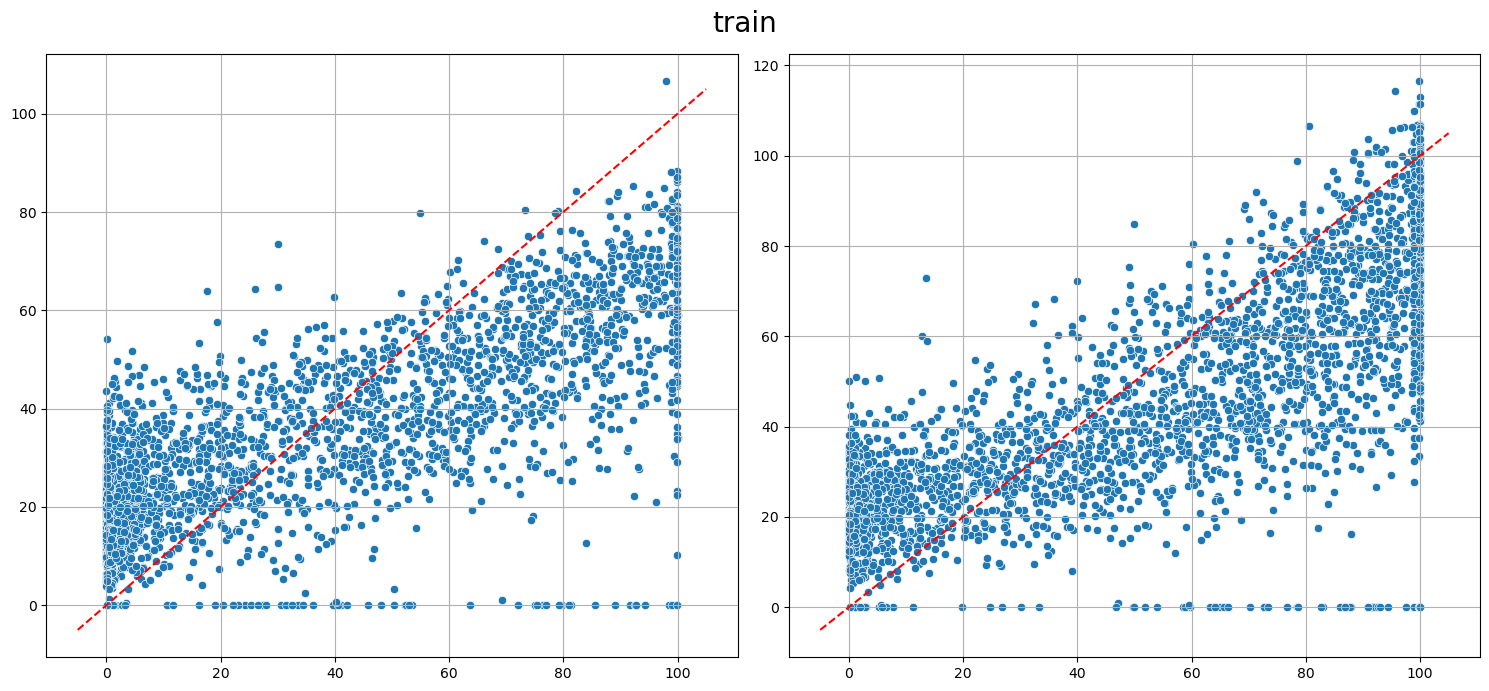

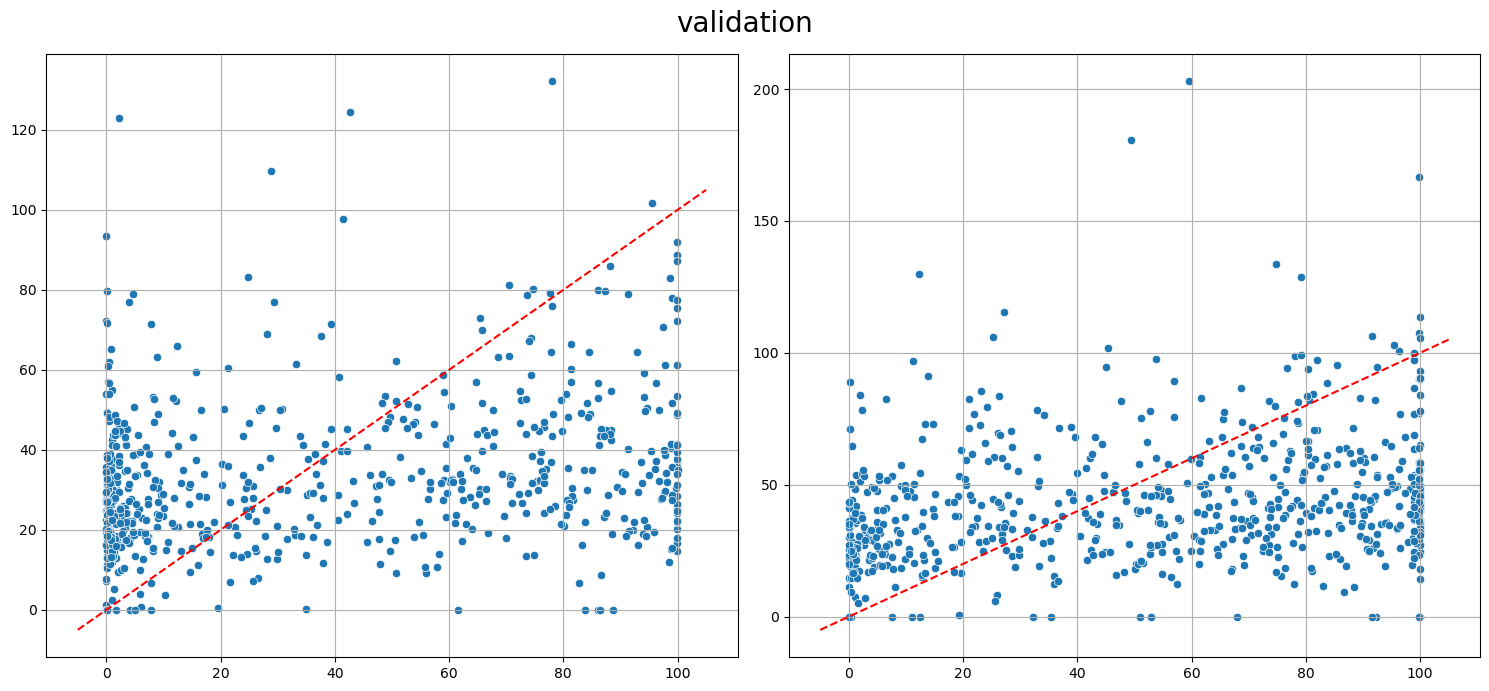

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(15,7))
fig.add_subplot(121)
sns.scatterplot(x=tr_true[:,0],y=tr_pred[:,0])
abline(0,1)
plt.grid()
fig.add_subplot(122)
sns.scatterplot(x=tr_true[:,1],y=tr_pred[:,1])
abline(0,1)
plt.grid()
plt.suptitle('train',fontsize=20)
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(15,7))
fig.add_subplot(121)
sns.scatterplot(x=va_true[:,0],y=va_pred[:,0])
abline(0,1)
plt.grid()
fig.add_subplot(122)
sns.scatterplot(x=va_true[:,1],y=va_pred[:,1])
abline(0,1)
plt.grid()
plt.suptitle('validation',fontsize=20)
plt.tight_layout()
plt.show()